**Training Models:**
- Linear Regression:

In [1]:
import numpy as np

In [2]:
from pyspark.sql import SparkSession
import pyspark.sql.functions as f
import os, sys

os.environ['PYSPARK_PYTHON'] = sys.executable
os.environ['PYSPARK_DRIVER_PYTHON'] = sys.executable

In [3]:
from pyspark import SparkConf
conf = SparkConf()
conf.set("spark.app.name","models")
conf.set("spark.master","local[*]")
conf.set("spark.driver.memory","8g")

In [4]:
spark = SparkSession.builder\
                    .config(conf=conf)\
                    .getOrCreate()

In [5]:
np.random.seed(42)

m = 100 # number of instances
X = 2 * np.random.rand(m,1) # column vector
y = 4 + 3*X + np.random.randn(m,1)

In [6]:
import matplotlib.pyplot as plt

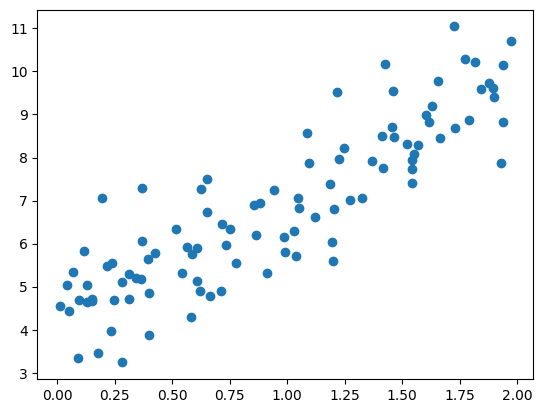

In [7]:
plt.scatter(x=X, y=y)
plt.show()

Now, let's compute the feature vector theta using the closed form solution (Normal equation). We will use the inv() function from NumPy's linear algebra module (np.linalg)

In [8]:
from sklearn.linear_model import LinearRegression

In [9]:
lin_reg = LinearRegression()
lin_reg.fit(X,y)

LinearRegression()

In [10]:
lin_reg.intercept_, lin_reg.coef_

(array([4.21509616]), array([[2.77011339]]))

In [11]:
X_new = np.array([[0], [2]])

In [12]:
X_new.shape

(2, 1)

In [13]:
lin_reg.predict(X_new)

array([[4.21509616],
       [9.75532293]])

In [14]:
from pyspark.ml.regression import LinearRegression
from pyspark.ml import Pipeline
from pyspark.ml.feature import VectorAssembler

In [15]:
from pyspark.sql.types import StructType, StructField, DoubleType

In [16]:
schema = StructType([
    StructField("features",DoubleType()),
    StructField("labels",DoubleType())
])

In [17]:
training_data = np.concatenate((X,y), axis=1)

In [18]:
data = spark.createDataFrame(training_data, schema=schema)

In [19]:
data.show()

+--------------------+-----------------+
|            features|           labels|
+--------------------+-----------------+
|   0.749080237694725|6.334287781322346|
|  1.9014286128198323| 9.40527848799363|
|  1.4639878836228102|8.483724427403931|
|  1.1973169683940732|5.604381990581327|
| 0.31203728088487304|4.716439954817107|
|  0.3119890406724053|5.293079693528962|
| 0.11616722433639892|5.826395717750713|
|  1.7323522915498704|8.678786656375964|
|  1.2022300234864176|6.798196467566066|
|   1.416145155592091|7.746678423191737|
|0.041168988591604894|5.038909083476889|
|  1.9398197043239886|10.14821022263165|
|  1.6648852816008435|8.464895641035492|
|  0.4246782213565523|5.787302097183012|
| 0.36364993441420124|5.188027352590644|
| 0.36680901970686763|6.069072049653492|
|  0.6084844859190754|5.123400363879874|
|  1.0495128632644757|6.820876443195659|
|  0.8638900372842315|6.199561958720537|
|  0.5824582803960838|4.283859893056133|
+--------------------+-----------------+
only showing top

In [20]:
assembler = VectorAssembler(inputCols=['features'],outputCol='featureVector')
regression_model = LinearRegression(featuresCol='featureVector',labelCol='labels',predictionCol='prediction')
pipeline = Pipeline(stages=[assembler,regression_model])

In [21]:
pipeline_model = pipeline.fit(data)

In [22]:
pipeline_model.stages[-1].coefficients

DenseVector([2.7701])

In [23]:
pipeline_model.stages[-1].intercept

4.215096157546755

In [24]:
data_new = spark.createDataFrame(X_new).withColumnRenamed("value","features")

In [25]:
pipeline_model.transform(data_new).show()

+--------+-------------+-----------------+
|features|featureVector|       prediction|
+--------+-------------+-----------------+
|       0|        [0.0]|4.215096157546755|
|       2|        [2.0]|9.755322930423713|
+--------+-------------+-----------------+



**Polynomial Regression:**
- You can use a linear model to fit nonlinear data. Way to do this is to add powers of each feature as new features, then train a linear model on this extended set of features. - Polynomial Regression

In [26]:
np.random.seed(42)

In [27]:
m = 100
X = 6*np.random.rand(m,1) - 3
y = 0.5 * X ** 2 + X + 2 + np.random.randn(m, 1)

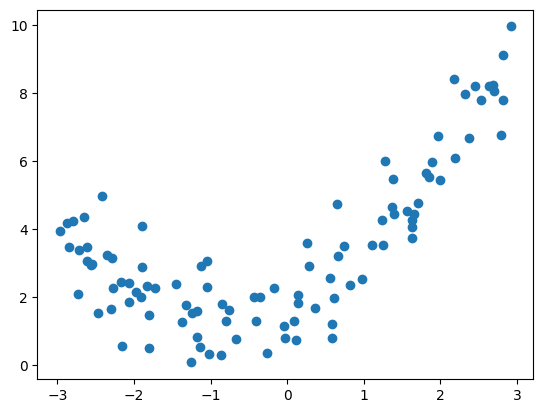

In [28]:
plt.scatter(x = X, y=y)
plt.show()

Straight line won't fit this data properly
- use scikit learn's polynomial features calss to transform the training data - adding the square of each feature in the training set as a new feature.

In [29]:
from sklearn.preprocessing import PolynomialFeatures

In [34]:
poly_features = PolynomialFeatures(degree=2,include_bias=False)

In [35]:
X_poly = poly_features.fit_transform(X)

In [36]:
X[0]

array([-0.75275929])

In [37]:
X_poly[0]

array([-0.75275929,  0.56664654])

In [38]:
from sklearn.linear_model import LinearRegression as sk_LinearRegression

In [39]:
lin_reg = sk_LinearRegression()
lin_reg.fit(X_poly,y)

LinearRegression()

In [40]:
lin_reg.intercept_, lin_reg.coef_

(array([1.78134581]), array([[0.93366893, 0.56456263]]))

In [42]:
y_pred = lin_reg.predict(X_poly)

In [43]:
X.shape

(100, 1)

In [44]:
y.shape

(100, 1)

In [45]:
y_pred.shape

(100, 1)

Polynomial Features in Pyspark

In [57]:
from pyspark.ml.feature import PolynomialExpansion

In [58]:
import pandas as pd

In [64]:
schema = StructType([
    StructField('features',DoubleType()),
    StructField('labels',DoubleType())
])

In [65]:
poly_data = spark.createDataFrame(np.concatenate((X,y),axis=1), schema=schema)

In [66]:
poly_data.show()

+-------------------+-------------------+
|           features|             labels|
+-------------------+-------------------+
| -0.752759286915825| 1.6176110533413568|
|  2.704285838459497|  8.061859436039922|
| 1.3919636508684308|  4.452505830073418|
| 0.5919509051822196| 0.7795849276543514|
|-2.0638881573453807|  1.846257117832363|
|-2.0640328779827843|   2.42319555422591|
|-2.6514983269908035|  4.341617406768227|
| 2.1970568746496113|  6.092316111598523|
|  0.606690070459253| 1.9822328883629923|
| 1.2484354667762734|  3.525973980544183|
|-2.8764930342251853|  4.176015171449896|
|  2.819459112971966|  9.122885067491984|
|   1.99465584480253|  5.454221610637939|
| -1.725965335930343|  2.276780267599584|
|-1.9090501967573963| 2.0102636794603708|
| -1.899572940879397| 2.8732607285140928|
|-1.1745465422427737| 0.8131801538271017|
|0.14853858979342682| 1.8319082995245686|
|-0.4083298881473052| 1.2829286074977326|
|-1.2526251588117485|0.06839478730021198|
+-------------------+-------------

In [69]:
from pyspark.ml.regression import LinearRegression as sp_LinearRegression

In [70]:
assembler = VectorAssembler(inputCols=['features'],outputCol='featureVector')
poly_expansion = PolynomialExpansion(degree=2,inputCol='featureVector',outputCol='polyfeatureVector')
linreg = sp_LinearRegression(featuresCol='polyfeatureVector',labelCol='labels')
pipeline = Pipeline(stages=[assembler,poly_expansion,linreg])

In [71]:
pipeline_model = pipeline.fit(poly_data)

In [72]:
pipeline_model.stages[-1].intercept,pipeline_model.stages[-1].coefficients

(1.781345812029148, DenseVector([0.9337, 0.5646]))

**Regularized Linear Models:**

Can either use Lasso (L1 Regularization) - meaning if highly regularized some weights can go to zero, or Ridge (L2 Regularization) - weights don't go to zero completely. Or try out Elastic Net Regularization - a combination of both Lasso and Ridge (L1 and L2) - Assigns weights on both of them. In pyspark the elastic net hyperparameter ranges from 0 to 1 - and at 0 => you have L2 regularization with L1 set to 0, and at 1 => L1 regularization - anything else is a mixture of both. 

L1 Regularization should be used with caution as some features might depend on each other and taking one out completely could result in bad results

Remember L1 Regularization - adds the weight component (L1 Norm) to the cost function whereas L2 Regularization adds the L2 Norm of the weights to the cost function. 

**Decision Boundaries:**


Using Logistic Regression - let's try to build a classifier to detect some type of plant (Iris Virginica) - based only on the petal width feature. 

In [73]:
from sklearn.datasets import load_iris

In [74]:
iris = load_iris(as_frame=True)

In [75]:
list(iris)

['data',
 'target',
 'frame',
 'target_names',
 'DESCR',
 'feature_names',
 'filename',
 'data_module']

In [76]:
iris.data.head(3)

,sepal length (cm),sepal width (cm),petal length (cm),petal width (cm)
0,5.1,3.5,1.4,0.2
1,4.9,3.0,1.4,0.2
2,4.7,3.2,1.3,0.2


In [77]:
iris.target.head(3)

0    0
1    0
2    0
Name: target, dtype: int32

In [78]:
iris.target_names

array(['setosa', 'versicolor', 'virginica'], dtype='<U10')

Next we split the data and train a logistic regression model on the training set:

In [79]:
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import train_test_split

In [80]:
X = iris.data[["petal width (cm)"]].values
y = iris.target_names[iris.target] == 'virginica'

In [81]:
X_train, X_test, y_train, y_test = train_test_split(X,y,random_state=42)

In [82]:
log_reg = LogisticRegression(random_state=42)
log_reg.fit(X_train,y_train)

LogisticRegression(random_state=42)

Model's estimated probabilities - for flowers with petal widths varying from 0cm to 3cm

In [ ]:
X_new = np.linspace(0,3,1000).reshape(-1,1)
y_proba = log_reg.predict_proba(X_new)


For multiclass prediction - model uses softmax not base logistic regression. And now that it is multiclass classification loss shifts from logloss(binary classification) to cross entropy - same as log loss but adapted for multiclass classification. Same idea - cross entropy penalizes the model when it estimates a low probability for a target class. Cross entropy is frequently used to measure how well a set of estimated class probabilities matches the target class.

Sklearn - automatically picks up the right loss and algo depending on the targets specified

In [83]:
X = iris.data[["petal length (cm)", "petal width (cm)"]].values
y = iris["target"]
X_train, X_test, y_train, y_test = train_test_split(X,y,random_state=42)

In [84]:
softmax_reg = LogisticRegression(C = 30, random_state=42)
softmax_reg.fit(X_train, y_train)

LogisticRegression(C=30, random_state=42)

In [85]:
softmax_reg.predict([[5,2]])

array([2])

In [88]:
softmax_reg.predict_proba([[5,2]]).round(2)

array([[0.  , 0.04, 0.96]])

Pyspark - Logistic Regression:

In [89]:
from pyspark.ml.classification import LogisticRegression as sp_LogisticRegression

In [ ]:
y_train.values

(112,)

In [97]:
y_train = y_train.values.reshape(-1,1)

In [93]:
X_train.shape,y_train.shape

((112, 2), (112,))

In [101]:
data = np.concatenate((X_train,y_train),axis=1)

In [102]:
data

array([[1.4, 0.2, 0. ],
       [1.5, 0.1, 0. ],
       [5.1, 1.9, 2. ],
       [4.5, 1.6, 1. ],
       [4.7, 1.5, 1. ],
       [1.3, 0.4, 0. ],
       [1.5, 0.2, 0. ],
       [3.7, 1. , 1. ],
       [5.1, 1.5, 2. ],
       [5.5, 1.8, 2. ],
       [4.4, 1.4, 1. ],
       [6.1, 2.5, 2. ],
       [4.2, 1.3, 1. ],
       [6.6, 2.1, 2. ],
       [4.5, 1.5, 1. ],
       [1.4, 0.2, 0. ],
       [6.7, 2. , 2. ],
       [4.1, 1. , 1. ],
       [1.4, 0.2, 0. ],
       [1.3, 0.3, 0. ],
       [1.9, 0.4, 0. ],
       [3.5, 1. , 1. ],
       [4.9, 1.8, 2. ],
       [1.9, 0.2, 0. ],
       [1.6, 0.2, 0. ],
       [1.7, 0.5, 0. ],
       [4.2, 1.3, 1. ],
       [1.5, 0.2, 0. ],
       [4.2, 1.2, 1. ],
       [6.7, 2.2, 2. ],
       [1.4, 0.2, 0. ],
       [4.3, 1.3, 1. ],
       [5. , 2. , 2. ],
       [1.4, 0.2, 0. ],
       [4.8, 1.8, 2. ],
       [5.1, 1.9, 2. ],
       [4. , 1. , 1. ],
       [4.5, 1.5, 1. ],
       [5.4, 2.3, 2. ],
       [4. , 1.3, 1. ],
       [1.7, 0.4, 0. ],
       [3.3, 1. 

In [104]:
from pyspark.sql.types import IntegerType

In [107]:
schema = StructType([
    StructField('feature1',DoubleType()),
    StructField('feature2',DoubleType()),
    StructField('labels',DoubleType()),
])

In [108]:
data = spark.createDataFrame(data,schema=schema)

In [109]:
data.show()

+--------+--------+------+
|feature1|feature2|labels|
+--------+--------+------+
|     1.4|     0.2|   0.0|
|     1.5|     0.1|   0.0|
|     5.1|     1.9|   2.0|
|     4.5|     1.6|   1.0|
|     4.7|     1.5|   1.0|
|     1.3|     0.4|   0.0|
|     1.5|     0.2|   0.0|
|     3.7|     1.0|   1.0|
|     5.1|     1.5|   2.0|
|     5.5|     1.8|   2.0|
|     4.4|     1.4|   1.0|
|     6.1|     2.5|   2.0|
|     4.2|     1.3|   1.0|
|     6.6|     2.1|   2.0|
|     4.5|     1.5|   1.0|
|     1.4|     0.2|   0.0|
|     6.7|     2.0|   2.0|
|     4.1|     1.0|   1.0|
|     1.4|     0.2|   0.0|
|     1.3|     0.3|   0.0|
+--------+--------+------+
only showing top 20 rows



In [111]:
data = data.withColumn("labels",f.col("labels").cast(IntegerType()))

In [112]:
assembler = VectorAssembler(inputCols=['feature1','feature2'],outputCol='featureVector')
logreg = sp_LogisticRegression(featuresCol='featureVector',labelCol='labels')
pipeline = Pipeline(stages=[assembler,logreg])

In [113]:
pipeline_model = pipeline.fit(data)

In [125]:
data_new = [(5.0,2.0)]

In [126]:
data_new = spark.createDataFrame(data_new,["feature1","feature2"])

In [128]:
preds = pipeline_model.transform(data_new)

In [129]:
preds.show()

+--------+--------+-------------+--------------------+--------------------+----------+
|feature1|feature2|featureVector|       rawPrediction|         probability|prediction|
+--------+--------+-------------+--------------------+--------------------+----------+
|     5.0|     2.0|    [5.0,2.0]|[-57.343870278767...|[6.00944290439441...|       2.0|
+--------+--------+-------------+--------------------+--------------------+----------+



In [131]:
preds.select("probability").collect()

[Row(probability=DenseVector([0.0, 0.019, 0.981]))]

In [132]:
spark.stop()